Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Train an image classification model with Azure Machine Learning

In this tutorial, you train a machine learning model on remote compute resources. You can then use the notebook as a template to train your own machine learning model with your own data.

This tutorial trains a simple logistic regression using the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset and [scikit-learn](http://scikit-learn.org) with Azure Machine Learning.  MNIST is a popular dataset consisting of 70,000 grayscale images. Each image is a handwritten digit of 28x28 pixels, representing a number from 0 to 9. The goal is to create a multi-class classifier to identify the digit a given image represents. 

Learn how to:

> * Set up your development environment
> * Access and examine the data
> * Train a simple logistic regression model on a remote cluster
> * Review training results, find and register the best model

### Import packages

Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.69


### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`.

In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

TestMLWS	northeurope	TestMLWS


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [3]:
experiment_name = 'sklearn-mnist'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

## Explore data

Before you train a model, you need to understand the data that you are using to train it. In this section you learn how to:

* Download the MNIST dataset
* Display some sample images

### Download the MNIST dataset

Download the MNIST dataset and save the files into a `data` directory locally.  Images and labels for both training and testing are downloaded.

In [4]:
import urllib.request

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename=os.path.join(data_folder, 'train-images.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename=os.path.join(data_folder, 'train-labels.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename=os.path.join(data_folder, 'test-images.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename=os.path.join(data_folder, 'test-labels.gz'))

('/mnt/azmnt/code/Users/AzureMLGettingStarted/notebooks/Alternative/data/test-labels.gz',
 <http.client.HTTPMessage at 0x7fea3c587908>)

### Display some sample images

Load the compressed files into `numpy` arrays. Then use `matplotlib` to plot 30 random images from the dataset with their labels above them. Note this step requires a `load_data` function that's included in an `utils.py` file. This file is included in the sample folder. Please make sure it is placed in the same folder as this notebook. The `load_data` function simply parses the compresse files into numpy arrays.

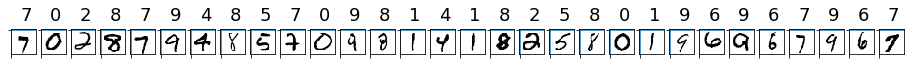

In [5]:
# make sure utils.py is in the same directory as this code
from utils import load_data

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

## Task 2: Upload Data to a Datastore

In Azure ML, *datastores* are references to storage locations, such as Azure Storage blob containers. Every workspace has a *default* datastore - usually the Azure storage blob container that was created with the workspace. If you need to work with data that is stored in different locations, you can add custom datastores to your workspace and set any of them to be the default.

Run the following code to determine the datastores in your workspace:

In [7]:
from azureml.core import Datastore

# Get the default datastore
datastore = ws.get_default_datastore()

# Enumerate all datastores, indicating which is the default
for ds_name in ws.datastores:
    print(ds_name, "- Default =", ds_name == datastore.name)

workspacefilestore - Default = False
workspaceblobstore - Default = True


Now that you have determined the available datastores, you can upload files from your local file system to a datastore so that it will be accessible to experiments running in the workspace, regardless of where the experiment script is actually being run.

In [8]:
datastore.upload_files(files=['./data/test-images.gz','./data/test-labels.gz','./data/train-images.gz','./data/train-labels.gz' ], # Upload the data/diabetes.csv file
                       target_path='mnist-data/', # Put it in a folder path in the datastore
                       overwrite=True, # Replace existing files of the same name
                       show_progress=True)

Uploading an estimated of 4 files
Uploading ./data/test-images.gz
Uploading ./data/test-labels.gz
Uploading ./data/train-images.gz
Uploading ./data/train-labels.gz
Uploaded ./data/train-labels.gz, 1 files out of an estimated total of 4
Uploaded ./data/test-labels.gz, 2 files out of an estimated total of 4
Uploaded ./data/test-images.gz, 3 files out of an estimated total of 4
Uploaded ./data/train-images.gz, 4 files out of an estimated total of 4
Uploaded 4 files


$AZUREML_DATAREFERENCE_723dd924bbff4a7fbc5437b83a36a80d

Note that the upload to the datastore results in the creation of a *data reference*, which is an abstraction that represents the connection to the data in the datastore.

So now there's a copy of the diabetes data in the default datastore for the workspace, that you can use in future experiments. If you like, you can use the *Storage Explorer* interface for the Azure Storage account that was created with your Azure ML workspace in the [Azure portal](https://portal.azure.com) to verify that the *diabetes.csv* file has been uploaded to a *diabetes-dataset* folder in the *azureml-blobstore-nnnn...* blob container.

We'll return to datastores later, but for now, let's turn our attention to another data-related object in Azure ML - the *dataset*.

## Task 3: Create and Register a Dataset

A dataset is an object that encapsulates a specific data source. Let's create a dataset from the diabetes data you uploaded to the datastore, and view the first 20 records. In this case, the data is in a structured format in a CSV file, so we'll use a *Tabular* dataset.

> **More Information**: See the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-create-register-datasets) for more information about creating datasets.

## Create a FileDataset
A FileDataset references single or multiple files in your datastores or public urls. The files can be of any format. FileDataset provides you with the ability to download or mount the files to your compute. By creating a dataset, you create a reference to the data source location. If you applied any subsetting transformations to the dataset, they will be stored in the dataset as well. The data remains in its existing location, so no extra storage cost is incurred. [Learn More](https://aka.ms/azureml/howto/createdatasets)

In [9]:
from azureml.core.dataset import Dataset

web_paths = [
            'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
            ]
dataset = Dataset.File.from_files(path = web_paths)

Use the `register()` method to register datasets to your workspace so they can be shared with others, reused across various experiments, and referred to by name in your training script.

In [10]:
dataset = dataset.register(workspace = ws,
                           name = 'mnist dataset',
                           description='training and test dataset',
                           create_new_version=True)

In [11]:
# list the files referenced by dataset
dataset.to_path()

array(['/http/yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
       '/http/yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
       '/http/yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
       '/http/yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'],
      dtype=object)

## Train on a remote cluster

### Create or Attach existing compute resource
By using Azure Machine Learning Compute, a managed service, data scientists can train machine learning models on clusters of Azure virtual machines. Examples include VMs with GPU support. In this tutorial, you create Azure Machine Learning Compute as your training environment. The code below creates the compute clusters for you if they don't already exist in your workspace.

**Creation of compute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace the code will skip the creation process.

In [12]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpu-cluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target. just use it. cpu-cluster


In [13]:
import os
script_folder = os.path.join(os.getcwd(), "sklearn-mnist")
os.makedirs(script_folder, exist_ok=True)

### Create a training script

To submit the job to the cluster, first create a training script. Run the following code to create the training script called `train.py` in the directory you just created. 

In [14]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np
import glob

from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

from azureml.core import Run
from utils import load_data

# let user feed in 2 parameters, the dataset to mount or download, and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

data_folder = args.data_folder
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data(glob.glob(os.path.join(data_folder, '**/train-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
X_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
y_train = load_data(glob.glob(os.path.join(data_folder, '**/train-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)
y_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularization rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

Writing /mnt/azmnt/code/Users/AzureMLGettingStarted/notebooks/Alternative/sklearn-mnist/train.py


Notice how the script gets data and saves models:

+ The training script reads an argument to find the directory containing the data.  When you submit the job later, you point to the dataset for this argument:
`parser.add_argument('--data-folder', type=str, dest='data_folder', help='data directory mounting point')`


+ The training script saves your model into a directory named outputs. <br/>
`joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')`<br/>
Anything written in this directory is automatically uploaded into your workspace. You'll access your model from this directory later in the tutorial.

The file `utils.py` is referenced from the training script to load the dataset correctly.  Copy this script into the script folder so that it can be accessed along with the training script on the remote resource.

In [15]:
import shutil
shutil.copy('utils.py', script_folder)

'/mnt/azmnt/code/Users/AzureMLGettingStarted/notebooks/Alternative/sklearn-mnist/utils.py'

### Create an estimator

An estimator object is used to submit the run. Azure Machine Learning has pre-configured estimators for common machine learning frameworks, as well as generic Estimator. Create SKLearn estimator for scikit-learn model, by specifying

* The name of the estimator object, `est`
* The directory that contains your scripts. All the files in this directory are uploaded into the cluster nodes for execution. 
* The compute target.  In this case you will use the AmlCompute you created
* The training script name, train.py
* Parameters required from the training script 

In this tutorial, the target is AmlCompute. All files in the script folder are uploaded into the cluster nodes for execution. The data_folder is set to use the dataset.

In [16]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# to install required packages
env = Environment('my_env')
cd = CondaDependencies.create(pip_packages=['azureml-sdk','scikit-learn','azureml-dataprep[pandas,fuse]>=1.1.14'])

env.python.conda_dependencies = cd

In [17]:
from azureml.train.sklearn import SKLearn

script_params = {
    # to mount files referenced by mnist dataset
    '--data-folder': dataset.as_named_input('mnist').as_mount(),
    '--regularization': 0.5
}

est = SKLearn(source_directory=script_folder,
              script_params=script_params,
              compute_target=compute_target,
              environment_definition=env,
              entry_script='train.py')

WARNING - If environment_definition or conda_dependencies_file_path is specified, Azure ML will not install any framework related packages on behalf of the user.
WARNING - This compute target type doesn't support non-Docker runs; overriding run configuration enable Docker.
WARNING - You have specified to install packages in your run. Note that you have overridden Azure ML's installation of the following packages: ['scikit-learn']. We cannot guarantee image build will succeed.


### Submit the job to the cluster

Run the experiment by submitting the estimator object. And you can navigate to Azure portal to monitor the run.

In [18]:
run = exp.submit(config=est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
sklearn-mnist,sklearn-mnist_1571935749_bb007a61,azureml.scriptrun,Starting,Link to Azure Portal,Link to Documentation


Since the call is asynchronous, it returns a **Preparing** or **Running** state as soon as the job is started.

## Monitor a remote run

In total, the first run takes **approximately 10 minutes**. But for subsequent runs, as long as the dependencies (`conda_packages` parameter in the above estimator constructor) don't change, the same image is reused and hence the container start up time is much faster.

Here is what's happening while you wait:

- **Image creation**: A Docker image is created matching the Python environment specified by the estimator. The image is built and stored in the ACR (Azure Container Registry) associated with your workspace. Image creation and uploading takes **about 5 minutes**. 

  This stage happens once for each Python environment since the container is cached for subsequent runs.  During image creation, logs are streamed to the run history. You can monitor the image creation progress using these logs.

- **Scaling**: If the remote cluster requires more nodes to execute the run than currently available, additional nodes are added automatically. Scaling typically takes **about 5 minutes.**

- **Running**: In this stage, the necessary scripts and files are sent to the compute target, then data stores are mounted/copied, then the entry_script is run. While the job is running, stdout and the files in the ./logs directory are streamed to the run history. You can monitor the run's progress using these logs.

- **Post-Processing**: The ./outputs directory of the run is copied over to the run history in your workspace so you can access these results.


You can check the progress of a running job in multiple ways. This tutorial uses a Jupyter widget as well as a `wait_for_completion` method. 

### Jupyter widget

Watch the progress of the run with a Jupyter widget.  Like the run submission, the widget is asynchronous and provides live updates every 10-15 seconds until the job completes.

In [19]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

By the way, if you need to cancel a run, you can follow [these instructions](https://aka.ms/aml-docs-cancel-run).

### Get log results upon completion

Model training happens in the background. You can use `wait_for_completion` to block and wait until the model has completed training before running more code. 

In [ ]:
# specify show_output to True for a verbose log
run.wait_for_completion(show_output=True) 

RunId: sklearn-mnist_1571935749_bb007a61
Web View: https://mlworkspace.azure.ai/portal/subscriptions/7d48758f-d40b-4252-854c-e7d8f2ed7645/resourceGroups/TestMLWS/providers/Microsoft.MachineLearningServices/workspaces/TestMLWS/experiments/sklearn-mnist/runs/sklearn-mnist_1571935749_bb007a61


### Display run results

You now have a model trained on a remote cluster.  Retrieve all the metrics logged during the run, including the accuracy of the model:

In [ ]:
print(run.get_metrics())

In the next tutorial you will explore this model in more detail.

## Register model

The last step in the training script wrote the file `outputs/sklearn_mnist_model.pkl` in a directory named `outputs` in the VM of the cluster where the job is executed. `outputs` is a special directory in that all content in this  directory is automatically uploaded to your workspace.  This content appears in the run record in the experiment under your workspace. Hence, the model file is now also available in your workspace.

You can see files associated with that run.

In [ ]:
print(run.get_file_names())

Register the model in the workspace so that you (or other collaborators) can later query, examine, and deploy this model.

In [ ]:
# register model 
model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
print(model.name, model.id, model.version, sep='\t')

## Next steps

In this Azure Machine Learning tutorial, you used Python to:

> * Set up your development environment
> * Access and examine the data
> * Train multiple models on a remote cluster using the popular scikit-learn machine learning library
> * Review training details and register the best model

You are ready to deploy this registered model using the instructions in the next part of the tutorial series:

> [Tutorial 2 - Deploy models](img-classification-part2-deploy.ipynb)

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/tutorials/img-classification-part1-training.png)